#Using Transfer Learning and TensorFlow  to Dettect Dogs Emotions 



Identifying Dogs Emotion is Hard

In this project we're going to be using machine learning to help us identify Emotions of a dog using an image

Emotions that we are going to detect is [ANGER,FEAR,HAPPY,NEUTRAL,SAD]

To do this, we'll be using data from the Kaggle dog breed identification competition and some google images.



This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different emotions of a  dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:

1)Get data ready ( store, import).

2)Prepare the data (preprocessing,).

3)Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, 
 EarlyStopping).

4)Evaluating a model (making predictions, comparing them with the ground truth labels).

5)Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow  The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

###The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

In [ ]:
import keras
from keras.models import load_model
from keras.preprocessing import image    
from keras.preprocessing.image import ImageDataGenerator, load_img  
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical  

import matplotlib.pyplot as plt 
import math  
import cv2
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.4.1
Hub version: 0.11.0
GPU available (YESS!!!!)


You might be wondering what a GPU is or why we need one. The short story is, a GPU is a computer chip which is faster at doing numerical computing. And since machine learning is all about finding patterns in numbers, that's what we're after.

Running this for the first time in Colab will let us know there's no GPU available.

This is because by default Colab runs on a computer located on Google's servers which doesn't have a GPU attached to it.

But we can fix this going to runtime and then changing the runtime type:

Go to Runtime.

Click "Change runtime type".

Where it says "Hardware accelerator",
 choose "GPU" 
Click save.

The runtime will be restarted to activate the new hardware,
 so you'll have to rerun the above cells.
 
If the steps have worked you should see a print out saying "GPU available".
If you want an example of how much a GPU speeds up computing, Google Colab have a demonstration notebook available.

##Getting Data Ready

upload it to your Google Drive, mount your drive in this notebook and import the file.


The Keras framework has an excellent utility called ImageDataGenerator that can help us in doing all the preceding operations. Let’s initialize two of the data generators for our training and validation datasets.

There are a lot of options available in ImageDataGenerator and we have just utilized a few of them. Feel free to check out the documentation to get a more detailed perspective. In our training data generator, we take in the raw images and then perform several transformations on them to generate new images. These include the following.

**Zooming** the image randomly by a factor of 0.3 using the zoom_range parameter.

**Rotating** the image randomly by 50 degrees using the rotation_range parameter.

**rescale** will  rescale pixel values from [0,255]

**Translating** the image randomly horizontally or vertically by a 0.2 factor of the image’s width or height using the width_shift_range and the height_shift_range parameters.
Applying shear-based transformations randomly using the shear_range parameter.

**Randomly** flipping half of the images horizontally using the horizontal_flip parameter.

Leveraging the **fill_mode** parameter to fill in new pixels for images after we apply any of the preceding operations (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

In [ ]:
batch_size = 32
np.random.seed(42)

data_dir='drive/MyDrive/SDGP/data'

train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=30,shear_range=0.2,zoom_range=0.2,width_shift_range=0.2
                                ,height_shift_range=0.5,horizontal_flip=True,fill_mode="nearest",validation_split=.10)
validation_datagen=ImageDataGenerator(rescale=1./255,validation_split=.10)

training=train_datagen.flow_from_directory(
    data_dir,
    subset="training",
    interpolation="bilinear", 
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True

)
testing=validation_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    interpolation="bilinear", 
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=None

)



Found 1395 images belonging to 5 classes.
Found 153 images belonging to 5 classes.


In [ ]:
unique_emotions = np.unique(training.labels)
print(len(unique_emotions))
unique_emotions
class_labels=['Angry','fear','Happy','Neutral','Sad']



5


Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers. 

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [ ]:
#trasforming the labels to boolean labels to visulize
boolean_train_lables=[label == np.array(unique_emotions) for label in training.labels]
boolean_test_lables=[label == np.array(unique_emotions) for label in testing.labels]



In [ ]:
X_train_1=training.filepaths
y_train_1=boolean_train_lables
X_test_1=testing.filepaths
y_test_1=boolean_test_lables

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images). 

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.


In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


In [ ]:
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

### Creating data batches

Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow [`BatchDataset`](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of `process_image` function at the same time.

In [ ]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train_1, y_train_1)
validation_data = create_data_batches(X_test_1, y_test_1, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec, validation_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)))

Look at that! We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [ ]:

def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(class_labels[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

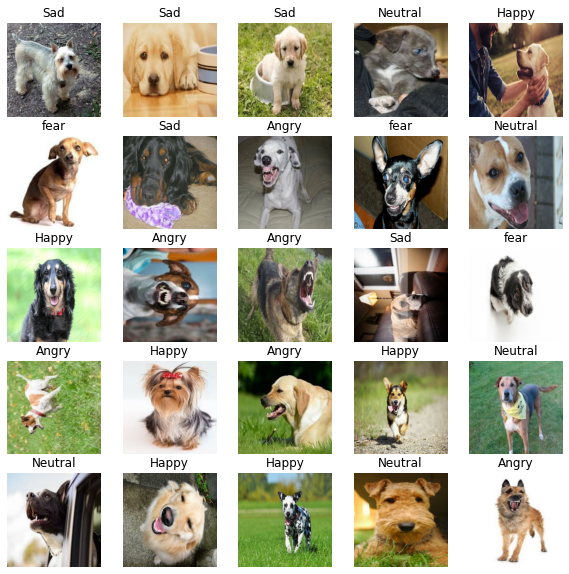

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)


## Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as **transfer learning**.

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

#### How do we choose a model?

Since we know our problem is image classification (classifying different dog emotions), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent). 

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [ ]:

# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_emotions) # number of unique labels

# Setup model URL from TensorFlow Hub
model='mobilenet'# @param ['nasnet_mobile','mobilenet','efficientb0']

model_url={
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",

    'mobilenet': "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
     'efficientb0': "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
}

model_select=model_url.get(model)


Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.


In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=model_select):
  print("Building model with:", model_url)

  # data_augmentation = keras.Sequential(
  #   [
  #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
  #                                                 input_shape=(224, 
  #                                                               224,
  #                                                               3)),
  #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  #     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  #   ]
  # )
  # resize_and_rescale = tf.keras.Sequential([
  #       tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  #       tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #  ])






  #Setup the model layers (way1)


  # model = tf.keras.Sequential([
  #   hub.KerasLayer(model_url,input_shape=(224, 224, 3),trainable=True), # Layer 1 (input layer)
  #   tf.keras.layers.Dropout(rate=0.2),
  #   tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.0001)) # Layer 2 (output layer)
  # ])

   #Setup the model layers (way2)


  model=tf.keras.Sequential([
       
    # Explicitly define the input shape so the model can be properly loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    hub.KerasLayer(model_url, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(OUTPUT_SHAPE,activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
  

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9 ), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )
# , momentum=0.9 #for SGD optimizer use

  # Build the model

  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

What's happening here?

#### Setting up the model layers

There are two ways to do this in Keras, the [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential API](https://www.tensorflow.org/guide/keras/overview#build_a_simple_model). We've used the sequential.

Which one should you use?

The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (a linear stack of layers) is perfectly fine for getting started, which is what we're doing.

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`. So our first layer is actually an entire model (many more layers). This **input layer** takes in our images and finds patterns in them based on the patterns [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) has found.

The next layer (`tf.keras.layers.Dense()`) is the **output layer** of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 5 (the number of unique emotions we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 5 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

For more on which activation function to use, see the article [Which Loss and Activation Functions Should I Use](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)?

#### Compiling the model

This one is best explained with a story.

Let's say you're at the international hill descending championships. Where your start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to `model.compile()` terminology:
* `loss` - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* `optimizer` - Your friend Adam or SGD or Aamax is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop ,SGD,Adagrad](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* `metrics` - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

#### Building the model

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as `None` as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call `summary()` on our model to get idea of what our model looks like.

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dropout (Dropout)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 5,437,723
Trainable params: 5,393,467
Non-trainable params: 44,256
_________________________________________________________________


The non-trainable parameters are the patterns learned by model and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks that we are going to use is ModelCheckpoint and EarlyStopping

#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [ ]:
 #saves only the best accuracy model to the location that we have given 
checkpoint =tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/SDGP/main/models/try1_data2.h5',
                              monitor='val_accuracy',
                            #  mode='min',
                             save_best_only=True,                 
                             verbose=1) #save the best accuracy model to  models folder


# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10) # stops after 10 rounds of no improvements


# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=3,
#                               verbose=1,
#                               min_delta=0.0001)

In [ ]:

# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


GPU available (YESS!!!!)


### Training a model


The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.

In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 60 #@param {type:"slider", min:10, max:100, step:10}

We've got a GPU running and `NUM_EPOCHS` setup. Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()


  steps_per_epoch = training.samples // training.batch_size

  validation_steps = testing.samples // testing.batch_size


  model.fit(x=training  ,
            epochs=NUM_EPOCHS,
            # steps_per_epoch=steps_per_epoch,
            # validation_steps=validation_steps,
            validation_data=testing,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[ early_stopping,checkpoint])
  
  return model

**Note:** When training a model for the first time, the first epoch will take a while to load compared to the rest. This is because the model is getting ready and the data is being initialised.  After the first epoch, subsequent epochs should take a few seconds.

In [ ]:
# Fit the model to the data and train

model = train_model()




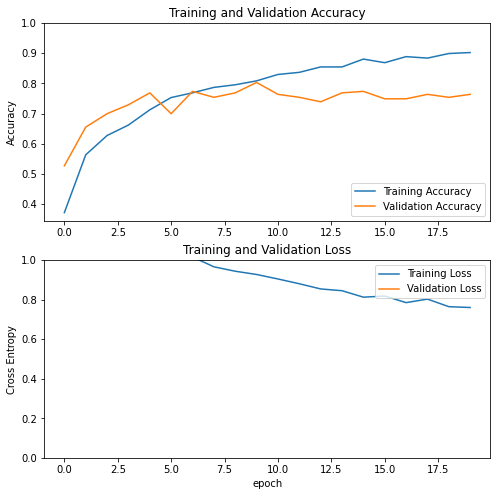

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 let's create a function which can take a model path and use the [`tf.keras.models.load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) function to load it into the notebook.

Because we're using a component from TensorFlow Hub (`hub.KerasLayer`) we'll have to pass this as a parameter to the `custom_objects` parameter.

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

## Making and evaluating predictions using a trained model

 let's see some  ways to evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling `predict()` on it and passing it data in the same format the model was trained on.

In [ ]:
# Load our model 

#model that we have trained on the mobilenet
model = load_model('/content/drive/MyDrive/SDGP/main/models/mobilenet_v2_emotion_new_sgd_fine_neww_1.h5')

#model that we have trained on efficientB0
model1=load_model('drive/MyDrive/SDGP/main/models/efficient_emotion.h5')


Loading saved model from: /content/drive/MyDrive/SDGP/main/models/mobilenet_v2_emotion_new_sgd_fine_neww_1.h5
Loading saved model from: drive/MyDrive/SDGP/main/models/efficient_emotion.h5


Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (153 images) returns an array (`predictions`) of arrays, each containing 5 different values (one for each unique dog emotions).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain emotion of a dog. The higher the value, the more likely the model thinks a given image is a specific emotion  of a dog.

Let's see how we'd convert an array of probabilities into an actual label.

In [ ]:
model.save("drive/MyDrive/SDGP/saved_model_emotion")

INFO:tensorflow:Assets written to: drive/MyDrive/SDGP/saved_model_emotion/assets


INFO:tensorflow:Assets written to: drive/MyDrive/SDGP/saved_model_emotion/assets


In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(validation_data, verbose=1) # verbose shows us how long there is to go
predictions1=model1.predict(validation_data,verbose=1)
predictions
print(predictions[0],predictions1[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {class_labels[np.argmax(predictions[0])]}") # the predicted label

5/5 [==============================] - 3s 481ms/step
[0.89201516 0.01925137 0.00629413 0.0741934  0.00824589] [0.8808136  0.02088099 0.00478787 0.06399466 0.02952298]
Max value (probability of prediction): 0.8920151591300964
Sum: 0.9999999403953552
Max index: 0
Predicted label: Angry


In [ ]:
#evaluating the model accuracy on the validation set 
model.evaluate(testing)  
model1.evaluate(testing)

5/5 [==============================] - 3s 550ms/step - loss: 1.0384 - accuracy: 0.8039


[1.0383554697036743, 0.8039215803146362]

looks like our best model is the first model compare to the other 

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[10])
pred_label

'Neutral'

Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [ ]:


# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_labels[np.argmax(label)])
  return images, labels

In [ ]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(validation_data)


In [ ]:
# image, label = next(iter(testing))
#evaluate

prob=model.predict(testing,verbose=1)
prob
len(prob)

predicted_label=prob.argsort()[:,4]
actual_label=testing.labels



5/5 [==============================] - 4s 574ms/step


**confusion matrix**
A confusion matrix is a quick way to compare the lablels a model predicts and  the actual labels it was supposed to predict

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(actual_label,predicted_label)

array([[27,  2,  0,  0,  1],
       [ 0, 19,  1,  1,  9],
       [ 0,  0, 27,  1,  1],
       [ 1,  2,  2, 24,  1],
       [ 1,  4,  0,  3, 26]])

In [ ]:
 pd.crosstab(actual_label,predicted_label,rownames=["actual labels"],colnames=["predicted labels"])

predicted labels,0,1,2,3,4
actual labels,,,,,
0,27,2,0,0,1
1,0,19,1,1,9
2,0,0,27,1,1
3,1,2,2,24,1
4,1,4,0,3,26


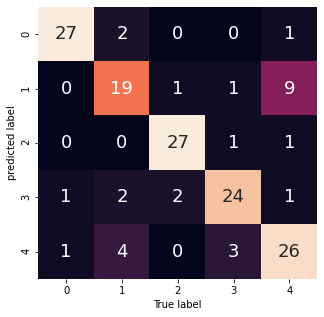

In [ ]:
import seaborn as sns

fig,ax=plt.subplots(figsize=(5,5))
sns.set(font_scale=1.5)

conf_mat=confusion_matrix(actual_label,predicted_label)

ax=sns.heatmap(conf_mat,annot=True,cbar=False);
plt.xlabel('True label');
plt.ylabel('predicted label');


**Precision**- indicates the propotion of positive identifications (model predicted class) which were actually correct. A model which produces no false positives has a precision of 1.0
precision tells us about when its predict yes,how often is it correct

Precision=TP/(TP+FP)

**Recall**- indicates the proportion of actual positives which were correctly classified. A model which produces no false negative has a recall 1.0
recall gives us an idea about when it is actually yes,how ofte does it predict yes

Recall =TP/(TP+FN)

**f1-score**- a combinaation of precision and recall.A perfect model achieves an f1 score of 1.0

**support** - the number of samples that each metric was calculated on 

**Accuracy**-the accuracy of the model

Accuracy=(TP+TF)/(TP+TF+FP+FN)

**Macroa avg**- the average precision,recall and F1 score  between classes.macro avg doesn't class imbalance into effect,so if you do have a class imbalances,pay attention to this metric

**weighted avg**- the weighted average precision,recall and f1 score between classes. weighted means ach metric is calculated with respect to how many samples there are in each class.This metric will favour the majority class(willl give a high value when on class out performs another due to having more samples)


In [ ]:
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score

print(classification_report(actual_label,predicted_label))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.70      0.63      0.67        30
           2       0.90      0.93      0.92        29
           3       0.83      0.80      0.81        30
           4       0.68      0.76      0.72        34

    accuracy                           0.80       153
   macro avg       0.81      0.81      0.81       153
weighted avg       0.81      0.80      0.80       153



In [ ]:
print(f"Accuracy:{accuracy_score(actual_label,predicted_label)*100 }")
print(f"Precision : {precision_score(actual_label,predicted_label,pos_label='positive',average='micro')}")
print(f"Recall : {recall_score(actual_label,predicted_label,pos_label='positive',average='micro')}")
print(f"f1-score:{f1_score(actual_label,predicted_label, average='micro')}")


Accuracy:80.3921568627451
Precision : 0.803921568627451
Recall : 0.803921568627451
f1-score:0.8039215686274509


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

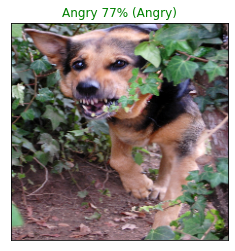

In [ ]:

# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,n=3)

(153, 153)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the  5 prediction confidence indexes
  top_5_pred_indexes = pred_prob.argsort()[-5:][::-1]
  # Find the  5 prediction confidence values
  top_5_pred_values = pred_prob[top_5_pred_indexes]
  # Find the  5 prediction labels
  top_5_pred_labels = np.array(class_labels)[top_5_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_5_pred_labels)), 
                     top_5_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_5_pred_labels)),
             labels=top_5_pred_labels,
             rotation="vertical")
  

  # Change color of true label
  if np.isin(true_label, top_5_pred_labels):
    top_plot[np.argmax(top_5_pred_labels == true_label)].set_color("green")
  else:
    pass

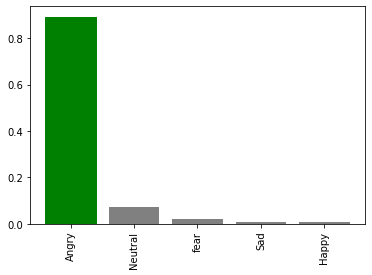

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,n=0)


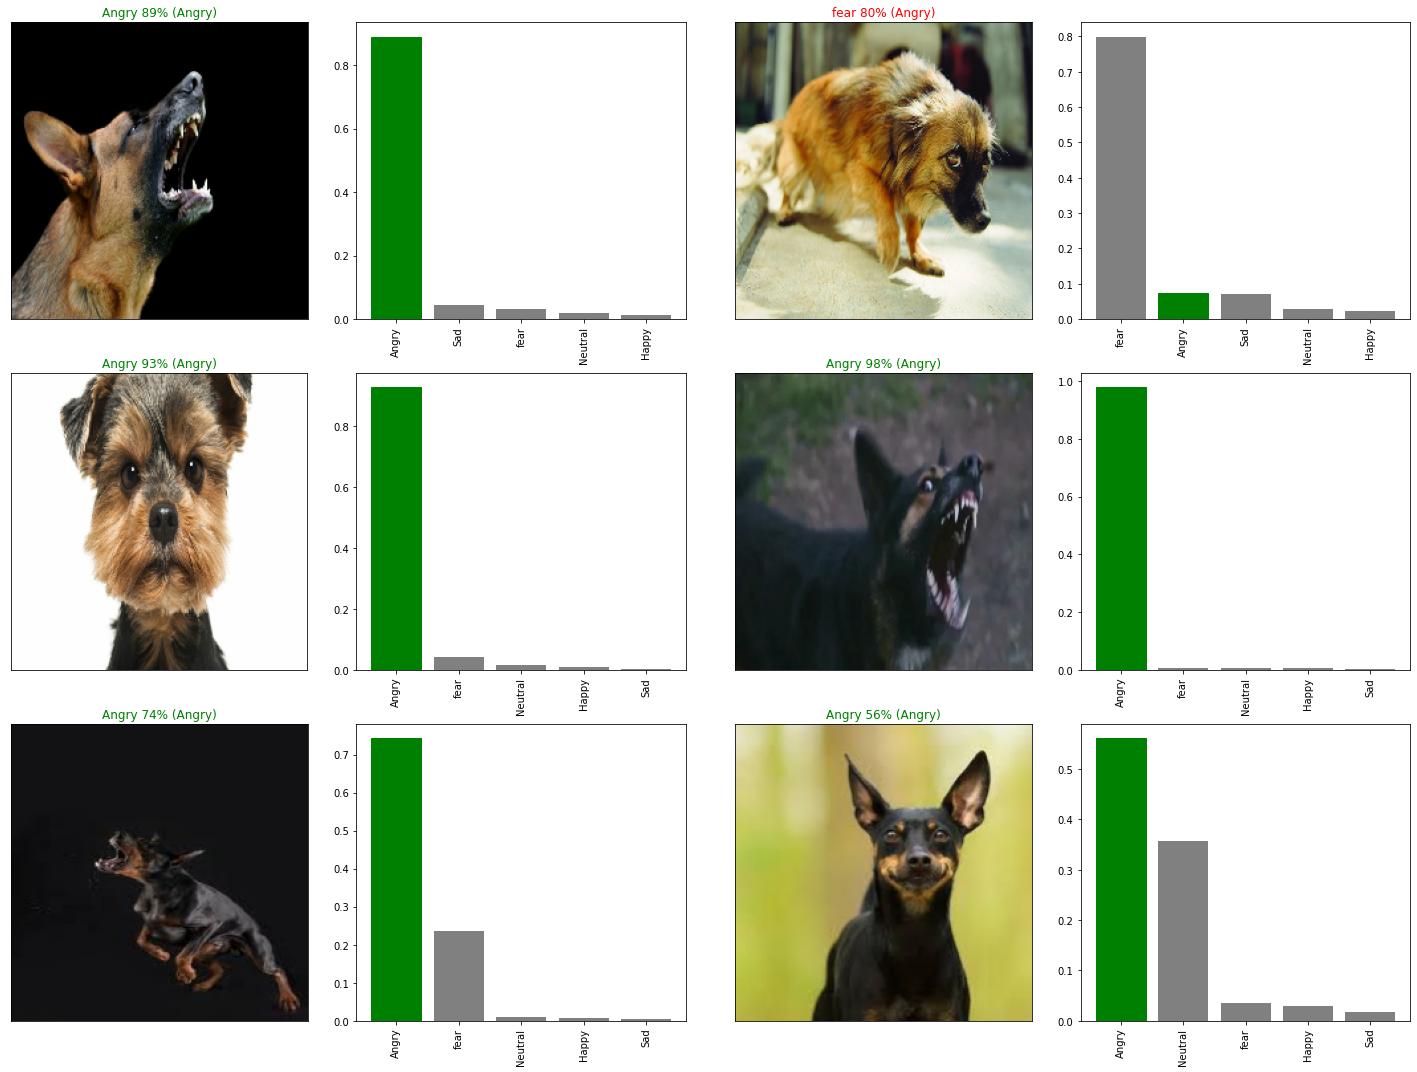

In [ ]:
# Let's check a few predictions and their different values
i_multiplier =20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

futher reading  : https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f

https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-4-unstructured-data-projects/end-to-end-dog-vision.ipynb

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

https://medium.com/@abhayakumar169/facial-expression-recognition-cf6a61f8045f